In [420]:
import pandas as pd
from datetime import datetime
from os.path import exists
ticker = 'NIO'
from_date = "2021-04-02"
to_date = '-'.join(datetime.today().isoformat('-').split('-')[0:-1])
cache_name = f'{ticker}_{from_date}_{to_date}.csv'

timestamp1 = round(datetime.fromisoformat(from_date).timestamp())
timestamp2 = round(datetime.today().timestamp())
if exists(f'csv_cache/{cache_name}'):
    print(f'{ticker} data found in cache.')
    df = pd.read_csv(f'csv_cache/{cache_name}', parse_dates=True, index_col=0, date_format='%Y-%m-%d')
else:
    print(f'Obtaining {ticker} from remote.')
    df = pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={timestamp1}&period2={timestamp2}&interval=1d&events=history&includeAdjustedClose=true', parse_dates=True, index_col=0)
    df.to_csv(f'csv_cache/{cache_name}')
df.index.name = 'Date'
print(df.tail())

Obtaining NIO from remote.
            Open  High   Low  Close  Adj Close    Volume
Date                                                    
2024-03-25  4.92  5.09  4.89   4.91       4.91  56419400
2024-03-26  4.90  4.92  4.77   4.78       4.78  83744700
2024-03-27  4.63  4.73  4.45   4.67       4.67  85346500
2024-03-28  4.68  4.74  4.48   4.50       4.50  55938500
2024-04-01  4.63  4.75  4.57   4.64       4.64  42475600


In [421]:
def z_score(x: pd.Series, window_size: int):
    window = x.rolling(window_size)
    mean = window.mean()
    std = window.std()
    return (x-mean)/std
def stochastic(x: pd.Series, high: pd.Series, low: pd.Series, n: int = 14, smoothing: int= 3):
    max_high = high.rolling(n).max()
    min_low = low.rolling(n).min()
    k = (x-min_low)/(max_high-min_low)
    return k.rolling(smoothing).mean().rolling(smoothing).mean()

In [422]:
df['z'] = z_score(df['Close'], 150)
df['s'] = stochastic(df['Close'], df['High'], df['Low'], 14)

In [423]:
from numpy import nan
data = df.dropna()

BASE_POSITION_SIZE_USD = 1000
POSITION_SIZE_USD = BASE_POSITION_SIZE_USD

df['entries'] = nan
df['exits'] = nan

entry_date = None
entry_price = None
stop = None

pl = 0
pl_perc = 1

for date, close, z_score, stoch in zip(df.index, df['Close'], df['z'], df['s']):
    if entry_price is None:
        if z_score <= -2 and stoch <= 0.2:
            entry_date = date
            entry_price = close
            stop = close * 0.9
            df.loc[date, 'entries'] = close
    else:
        if close <= stop:
            df.loc[date, 'exits'] = close
            pl += POSITION_SIZE_USD*(close/entry_price) - POSITION_SIZE_USD
            pl_perc *= close / entry_price
            POSITION_SIZE_USD = BASE_POSITION_SIZE_USD * pl_perc
            entry_price = None
            stop = None
        else:
            STOP_PERC = (1-1/close)**(1/30)
            STOP_PERC = 0.9
            stop = max(stop, close * STOP_PERC)
            


total_time = df['entries'].dropna().index[-1] - df['entries'].dropna().index[0]
print(f'Profit: ${pl:.2f} ({100*(pl_perc-1):.2f}%) over {total_time.days} days.')
print(f'Avg. profit per day: ${pl/total_time.days:.2f} ({100*(pl_perc**(1/total_time.days)-1):.5f}%)')
print(f'Avg. profit per week: ${7 * pl/total_time.days:.2f} ({100*(pl_perc**(7 * 1/total_time.days)-1):.5f}%)')
print(f'Avg. profit per year: ${365.25 * pl/total_time.days:.2f} ({100*(pl_perc**(365.25 * 1/total_time.days)-1):.5f}%)')
print(f'Avg. pl per entry {100*(pl_perc**(1/len(df['exits'].dropna())-1)):.2f}% ({len(df['exits'].dropna())} entries exited)')
print(f'Profits assume starting position of ${BASE_POSITION_SIZE_USD:.2f}. Further position sizes are rolled entirely from the previous.')


Profit: $-376.22 (-37.62%) over 312 days.
Avg. profit per day: $-1.21 (-0.15115%)
Avg. profit per week: $-8.44 (-1.05329%)
Avg. profit per year: $-440.43 (-42.44935%)
Avg. pl per entry 153.58% (11 entries exited)
Profits assume starting position of $1000.00. Further position sizes are rolled entirely from the previous.


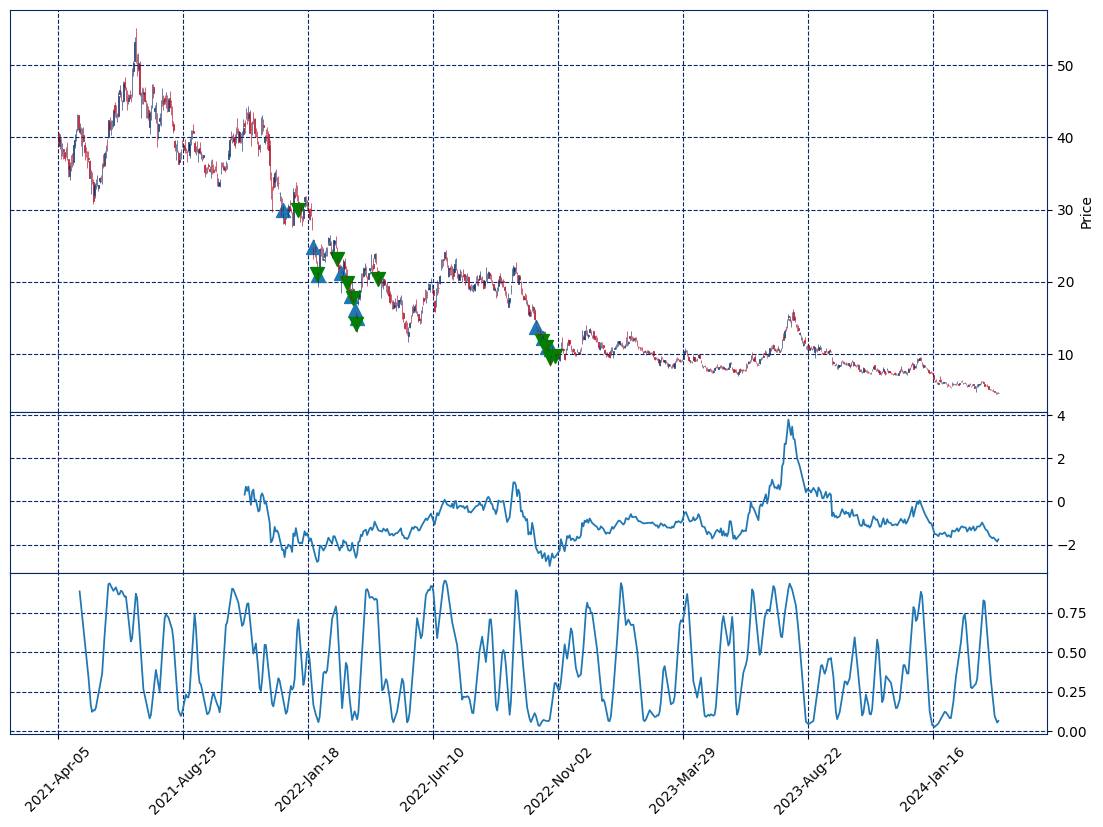

In [424]:
import mplfinance as mpf

inds_dict = [
    mpf.make_addplot(df['z'], panel=1),
    mpf.make_addplot(df['s'], panel=2),
    mpf.make_addplot(df['entries'], type='scatter', markersize=100, marker='^'),
    mpf.make_addplot(df['exits'], type='scatter', markersize=100, marker='v', color='g')
]

mpf.plot(df, 
         type='candle', 
         addplot=inds_dict,
         volume=False,
         style='sas',
         figscale=1.8,
         warn_too_much_data=10**10
         )
